<a href="https://colab.research.google.com/github/AtaruOhto/pytorch_learning/blob/master/002_jma_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import torch


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# 気象庁が配布している東京の日中平均気温のデータ (2012年〜2020年) をダウンロードして読み込む
# https://www.data.jma.go.jp/gmd/risk/obsdl/index.php
data = pd.read_csv("./jma_tokyo_2012_2020_temperture.csv", encoding="shift-jis", skiprows=[0,1,2,4])
data

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,2012/1/1,5.7,8,1
1,2012/1/2,6.0,8,1
2,2012/1/3,6.6,8,1
3,2012/1/4,5.4,8,1
4,2012/1/5,5.5,8,1
...,...,...,...,...
2918,2019/12/28,6.8,8,2
2919,2019/12/29,7.0,8,2
2920,2019/12/30,6.7,8,2
2921,2019/12/31,8.2,8,2


In [106]:
temperature = data["平均気温(℃)"]
temperature

0       5.7
1       6.0
2       6.6
3       5.4
4       5.5
       ... 
2918    6.8
2919    7.0
2920    6.7
2921    8.2
2922    5.5
Name: 平均気温(℃), Length: 2923, dtype: float64

In [107]:
train_x = temperature[:1827]
test_x = temperature[1827:]
train_x = np.array(train_x)
test_x = np.array(test_x)

In [108]:
# ミニバッチ用のデータを作る
window_size = 180
temperature_series = []
train_X_series = []

for i in range(0, len(train_x) - window_size):
  # 一個ずつデータをずらしながら格納していく
  temperature_series.append(train_x[i:i+ window_size])

train_X_series = np.array(temperature_series)
pd.DataFrame(train_X_series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,5.7,6.0,6.6,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,...,21.3,20.2,14.6,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5
1,6.0,6.6,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,...,20.2,14.6,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4
2,6.6,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,5.4,...,14.6,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4,23.3
3,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,5.4,5.0,...,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4,23.3,21.9
4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,5.4,5.0,5.8,...,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4,23.3,21.9,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,23.0,25.6,27.0,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,...,12.6,11.3,9.8,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9
1643,25.6,27.0,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,31.9,...,11.3,9.8,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9,11.1
1644,27.0,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,31.9,29.1,...,9.8,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9,11.1,6.0
1645,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,31.9,29.1,27.3,...,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9,11.1,6.0,4.3


100 8.126312255859375
200 5.395981311798096
300 5.452592372894287
400 5.431098937988281
500 5.088223457336426
600 5.253445148468018
700 5.182444095611572
800 5.115572452545166
900 5.152064800262451
1000 5.071608066558838
1100 4.742990016937256
1200 4.551145076751709
1300 4.4912028312683105
1400 4.470078945159912
1500 4.248929023742676
1600 3.9436471462249756
1700 4.087114334106445
1800 4.013820648193359
1900 3.8785152435302734
2000 3.6719839572906494


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,tensor(12.9000),tensor(18.3000),tensor(19.7000),tensor(17.4000),tensor(11.7000),tensor(13.2000),tensor(13.7000),tensor(11.),tensor(9.8000),tensor(9.4000),tensor(8.3000),tensor(15.),tensor(16.),tensor(9.),tensor(7.4000),tensor(11.2000),tensor(10.6000),tensor(13.7000),tensor(17.2000),tensor(18.1000),tensor(17.4000),tensor(17.7000),tensor(14.7000),tensor(16.9000),tensor(13.6000),tensor(9.7000),tensor(11.4000),tensor(12.3000),tensor(16.6000),tensor(17.2000),tensor(16.4000),tensor(20.9000),tensor(19.9000),tensor(14.5000),tensor(9.2000),tensor(7.4000),tensor(11.8000),tensor(14.3000),tensor(16.8000),tensor(18.),...,tensor(27.8000),tensor(29.1000),tensor(28.7000),tensor(30.),tensor(30.3000),tensor(31.),tensor(33.2000),tensor(32.9000),tensor(31.3000),tensor(30.),tensor(30.2000),tensor(30.),tensor(29.7000),tensor(29.6000),tensor(29.6000),tensor(30.3000),tensor(30.5000),tensor(29.1000),tensor(28.5000),tensor(28.2000),tensor(29.),tensor(25.5000),tensor(26.7000),tensor(25.4000),tensor(27.8000),tensor(28.3000),tensor(31.4000),tensor(30.8000),tensor(30.4000),tensor(29.),tensor(29.6000),tensor(27.9000),tensor(27.5000),tensor(26.),tensor(25.9000),tensor(25.2000),tensor(24.6000),tensor(24.8000),tensor(24.7000),tensor(27.6000)
1,tensor(24.2000),tensor(17.2000),tensor(21.3000),tensor(20.),tensor(20.3000),tensor(21.),tensor(22.4000),tensor(20.3000),tensor(18.6000),tensor(18.1000),tensor(23.1000),tensor(15.9000),tensor(16.8000),tensor(18.4000),tensor(17.5000),tensor(18.3000),tensor(19.4000),tensor(19.),tensor(16.1000),tensor(14.3000),tensor(16.7000),tensor(18.3000),tensor(20.1000),tensor(19.3000),tensor(15.8000),tensor(16.4000),tensor(16.8000),tensor(18.4000),tensor(16.8000),tensor(19.5000),tensor(18.),tensor(16.2000),tensor(15.2000),tensor(17.7000),tensor(17.7000),tensor(14.1000),tensor(14.9000),tensor(17.8000),tensor(14.5000),tensor(14.1000),...,tensor(6.2000),tensor(6.3000),tensor(10.7000),tensor(9.7000),tensor(9.2000),tensor(6.6000),tensor(8.2000),tensor(7.4000),tensor(6.9000),tensor(9.3000),tensor(5.6000),tensor(9.6000),tensor(9.3000),tensor(7.3000),tensor(6.),tensor(8.2000),tensor(9.),tensor(7.7000),tensor(6.2000),tensor(8.6000),tensor(8.9000),tensor(8.9000),tensor(8.4000),tensor(11.1000),tensor(14.5000),tensor(14.8000),tensor(11.9000),tensor(11.8000),tensor(10.5000),tensor(12.9000),tensor(10.7000),tensor(8.2000),tensor(8.1000),tensor(9.5000),tensor(12.3000),tensor(14.1000),tensor(14.6000),tensor(16.2000),tensor(16.7000),tensor(13.9000)
2,tensor(21.7000),tensor(19.3000),tensor(20.),tensor(19.6000),tensor(21.9000),tensor(21.2000),tensor(23.5000),tensor(23.5000),tensor(23.9000),tensor(19.8000),tensor(22.2000),tensor(20.8000),tensor(22.1000),tensor(24.2000),tensor(26.7000),tensor(24.3000),tensor(24.3000),tensor(22.7000),tensor(22.7000),tensor(23.),tensor(22.7000),tensor(25.4000),tensor(25.5000),tensor(24.4000),tensor(19.1000),tensor(21.5000),tensor(23.),tensor(25.6000),tensor(27.),tensor(29.2000),tensor(27.8000),tensor(21.7000),tensor(23.1000),tensor(27.4000),tensor(25.3000),tensor(22.4000),tensor(25.6000),tensor(28.),tensor(27.1000),tensor(25.1000),...,tensor(16.7000),tensor(18.1000),tensor(14.9000),tensor(14.),tensor(19.1000),tensor(19.),tensor(12.2000),tensor(15.5000),tensor(11.9000),tensor(14.3000),tensor(13.4000),tensor(10.9000),tensor(12.9000),tensor(14.),tensor(14.6000),tensor(14.8000),tensor(11.),tensor(9.9000),tensor(10.4000),tensor(9.6000),tensor(9.),tensor(13.6000),tensor(13.6000),tensor(13.7000),tensor(15.3000),tensor(12.5000),tensor(12.6000),tensor(11.3000),tensor(9.8000),tensor(13.6000),tensor(12.6000),tensor(14.),tensor(11.4000),tensor(2.8000),tensor(5.6000),tensor(8.3000),tensor(10.6000),tensor(11.1000),tensor(10.5000),tensor(8.8000)
3,tensor(29.6000),tensor

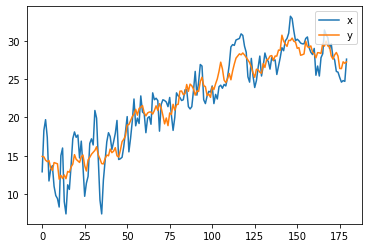

In [128]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(window_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 128)   
    self.fc4 = nn.Linear(128, 180)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

model = Net()

# 最小二乗誤差
#  ((input - target) **2).mean()
criterion = nn.MSELoss()

# optimizerはAdam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2000エポック回す
for epoch in range(2000):
  total_loss = 0
  optimizer.zero_grad()

  # ランダムに特徴量を格納する
  features_x = []

  for i in range(100):
    random_data_index = np.random.randint(0, len(train_X_series))
    # 訓練データ、train_X_seriesの中から、ランダムに特徴量を取得して格納する。
    features_x.append(train_X_series[random_data_index])

  # ランダムに抽出した特徴量をニューラルネットワークに通してyを得る
  features_x = torch.Tensor(features_x)
  y = model(features_x)

  # 誤差を算出
  loss = criterion(y, features_x)

  # 勾配を計算
  loss.backward()
  optimizer.step()
  total_loss += loss.item()

  if (epoch + 1) % 100 == 0:
    print(epoch + 1, total_loss)


plt.plot(features_x.data[0].numpy(), label="x")
plt.plot(y.data[0].numpy(), label="y")
plt.legend(loc="upper right")





In [164]:
# 誤差を検出する

test_x_extract = []
test_x_extract.append(test_x[0:180])
test_x_extract.append(test_x[180:360])
test_x_tensor = torch.Tensor(np.array(test_x_extract, dtype="float32"))

pd.DataFrame()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,tensor(7.4000),tensor(7.2000),tensor(8.),tensor(8.5000),tensor(6.7000),tensor(4.5000),tensor(4.1000),tensor(3.9000),tensor(7.2000),tensor(8.1000),tensor(6.9000),tensor(6.),tensor(6.2000),tensor(2.4000),tensor(0.7000),tensor(3.2000),tensor(5.4000),tensor(5.8000),tensor(6.4000),tensor(3.),tensor(5.9000),tensor(6.),tensor(4.),tensor(2.5000),tensor(3.9000),tensor(4.6000),tensor(8.8000),tensor(8.4000),tensor(8.),tensor(11.2000),tensor(5.9000),tensor(6.),tensor(4.5000),tensor(7.4000),tensor(8.2000),tensor(7.2000),tensor(8.7000),tensor(5.6000),tensor(6.3000),tensor(2.4000),...,tensor(23.8000),tensor(23.2000),tensor(22.5000),tensor(22.2000),tensor(20.9000),tensor(18.8000),tensor(20.9000),tensor(20.9000),tensor(21.5000),tensor(23.3000),tensor(23.6000),tensor(21.5000),tensor(23.),tensor(21.4000),tensor(21.),tensor(19.6000),tensor(19.6000),tensor(20.3000),tensor(22.),tensor(23.1000),tensor(24.6000),tensor(21.7000),tensor(20.5000),tensor(16.9000),tensor(19.3000),tensor(21.3000),tensor(22.4000),tensor(22.3000),tensor(19.5000),tensor(22.6000),tensor(22.7000),tensor(22.4000),tensor(24.),tensor(24.6000),tensor(24.6000),tensor(22.3000),tensor(23.1000),tensor(23.2000),tensor(22.4000),tensor(24.6000)
1,tensor(23.8000),tensor(23.4000),tensor(25.7000),tensor(28.3000),tensor(26.8000),tensor(26.3000),tensor(26.2000),tensor(27.),tensor(27.9000),tensor(27.3000),tensor(27.4000),tensor(27.7000),tensor(28.9000),tensor(28.5000),tensor(28.2000),tensor(28.1000),tensor(28.9000),tensor(29.7000),tensor(26.3000),tensor(26.5000),tensor(28.2000),tensor(29.1000),tensor(28.7000),tensor(27.3000),tensor(29.1000),tensor(29.4000),tensor(24.6000),tensor(24.2000),tensor(26.8000),tensor(26.8000),tensor(25.6000),tensor(28.),tensor(26.3000),tensor(22.9000),tensor(24.3000),tensor(25.6000),tensor(27.8000),tensor(29.),tensor(28.7000),tensor(29.3000),...,tensor(9.9000),tensor(10.7000),tensor(8.6000),tensor(6.4000),tensor(7.9000),tensor(7.1000),tensor(9.4000),tensor(9.4000),tensor(9.1000),tensor(11.6000),tensor(11.4000),tensor(11.6000),tensor(12.7000),tensor(11.),tensor(8.5000),tensor(7.6000),tensor(8.2000),tensor(8.8000),tensor(9.2000),tensor(6.9000),tensor(6.4000),tensor(5.7000),tensor(5.9000),tensor(6.9000),tensor(9.9000),tensor(6.8000),tensor(5.9000),tensor(5.7000),tensor(5.4000),tensor(7.7000),tensor(6.1000),tensor(4.4000),tensor(6.5000),tensor(5.7000),tensor(5.3000),tensor(5.4000),tensor(7.1000),tensor(7.4000),tensor(9.4000),tensor(7.5000)


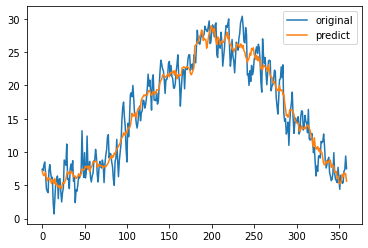

In [173]:
predict = model(test_x_tensor)

plt.plot(test_x_tensor.flatten(), label="original")
plt.plot(predict.data.flatten(), label="predict")
plt.legend(loc="upper right")

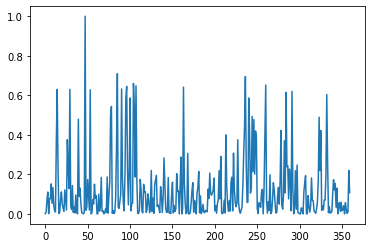

In [195]:
test = test_x_tensor.flatten()
predict = predict.data.flatten()

losses = []

for i in range(0, 360):
  diff = test[i] - predict[i]
  loss = pow(diff, 2)
  losses.append(loss)
  
losses = torch.Tensor(losses)

# 一番誤差が大きい値
max_loss_value = torch.max(losses)

# 一番誤差が大きい値で割る。最大値は1となる。
# 比率で誤差を表示する。
loss_ratios = losses / max_loss_value
plt.plot(loss_ratios)